Сегодня мы будем работать с линейной регрессией в библиотеке sklearn. Воспользуемся классами с различным типом регуляризации и подберем оптимальные гипер-параметры для этих моделей. Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Первым делом необходимо скачать данные. Воспользуемся следующей инструкцией: [Как скачать данные с kaggle в colab.](https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8) Ниже есть необходимый код, нужно лишь запрость токен на kaggle и загрузить его.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()
# upload your kaggle API (kaggle.json)

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!kaggle competitions download -c nyc-taxi-trip-duration --force

Распакуем данные, которые мы загрузили. Работать будем только с train частью, так как там имеются значения предсказываемой переменной.

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и так далее. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

Сейчас даты записаны в виде строк. Преобразуем их в datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получится. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [ ]:
df = df.drop('dropoff_datetime', axis=1)
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df = df.sort_values(by='pickup_datetime')
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [ ]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

Мы будем пресказывать переменную trip_duration. Посмотрим на target переменную.

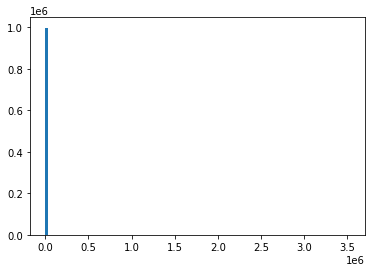

In [ ]:
df_train.trip_duration.hist(bins=100, grid=False)

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые, например, мнгновенно завершились.

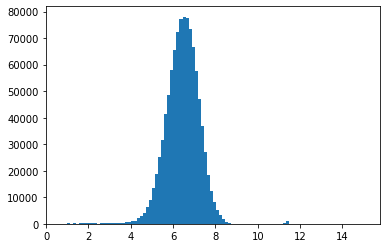

In [ ]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False)

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [ ]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

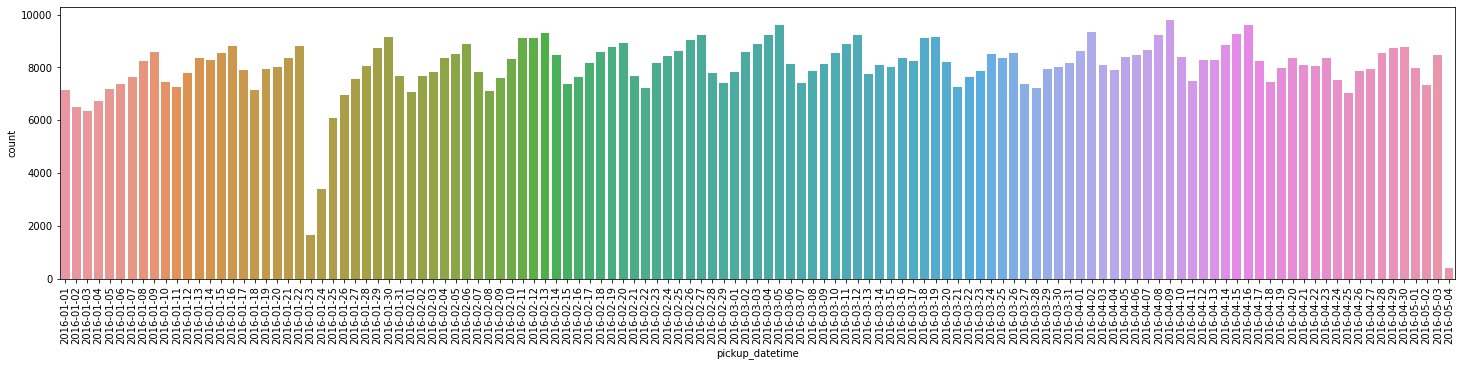

In [ ]:
date = df_train.pickup_datetime.apply(lambda x: x.date())

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(x=date)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


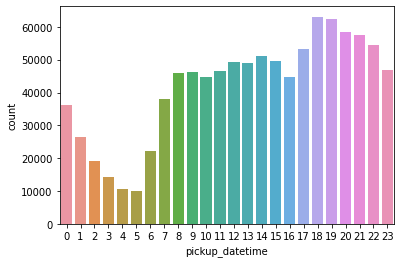

In [ ]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
)

# Задание 1
Постройте график соответствующий количеству поездок в зависимости от дня недели по обучающей выборке.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


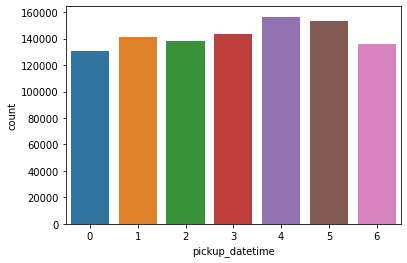

In [ ]:
sns.countplot(
    df_train.pickup_datetime.apply(lambda x: x.dayofweek)
)

Теперь давайте посмотрим, как связан день и длина поездки.

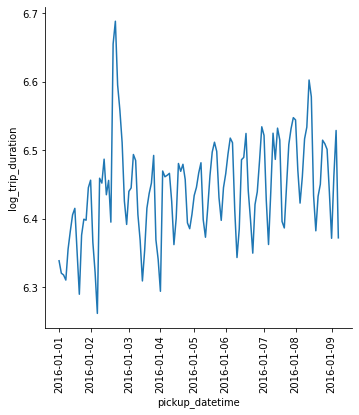

In [ ]:
group_by_weekday = df_train.groupby(date)
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line').set_xticklabels(date_count_plot.get_xticklabels(), rotation=90)


Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

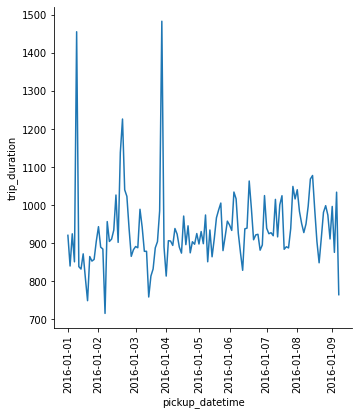

In [ ]:
group_by_weekday = df_train.groupby(date)
sns.relplot(data=group_by_weekday.trip_duration.aggregate('mean'), kind='line').set_xticklabels(date_count_plot.get_xticklabels(), rotation=90)

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `create_features`, которая будет собирать нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией как для train подвыборки, так и для test.

In [ ]:
import datetime
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
  )
  
  return X, data_frame.log_trip_duration

# Задание 2
Добавьте к признакам бинарную переменную, которая равна 1 для двух аномальных дней и 0 во все остальные дни.
Для этого вам понадобиться модифицировать функцию create_features.

In [ ]:
def create_features_a(data_frame):
  X = pd.concat([
                 data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
                 data_frame.pickup_datetime.apply(lambda x: x.hour),
                 data_frame.pickup_datetime.apply(lambda x: 1 if x.date() == datetime.date(2016, 1, 24) or
                                                  x.date() == datetime.date(2016, 1, 23) else 0),
                 data_frame.pickup_datetime.apply(lambda x: x.dayofweek)
  ], axis=1, keys=['day', 'hour', 'is_anomalous', 'day_of_week']
  )

  return X, data_frame.log_trip_duration

# Задание 3
1. Добавьте день недели в качестве признака для обучения. Удобнее всего - модифицировать функцию create_features.

2. Проведите one-hot кодирование. Сколько признаков у вас получилось?

In [ ]:
X_train, y_train = create_features_a(df_train)
X_test, y_test = create_features_a(df_test)

,day,hour,is_anomalous,day_of_week
96469,1,0,0,4
223872,1,0,0,4
713067,1,0,0,4
652463,1,0,0,4
722901,1,0,0,4


In [ ]:
X_train

,day,hour,is_anomalous,day_of_week
96469,1,0,0,4
223872,1,0,0,4
713067,1,0,0,4
652463,1,0,0,4
722901,1,0,0,4
...,...,...,...,...
1384418,125,3,0,2
1100978,125,3,0,2
630885,125,3,0,2
567651,125,3,0,2


In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_train_scaled

array([[-1.77679488, -2.13487652, -0.07110864,  0.47827577],
       [-1.77679488, -2.13487652, -0.07110864,  0.47827577],
       [-1.77679488, -2.13487652, -0.07110864,  0.47827577],
       ...,
       [ 1.73135511, -1.66477581, -0.07110864, -0.53827893],
       [ 1.73135511, -1.66477581, -0.07110864, -0.53827893],
       [ 1.73135511, -1.66477581, -0.07110864, -0.53827893]])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1, 3])], remainder="passthrough")
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
X_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

33 признака после OHE

# Задание 4

1. Отмасштабируйте единственный вещественный признак.
2. Обучите на полученных данных Lasso регрессию, в качества параметра  `alpha` возьмите 2.65e-05.

Какое качество в терминах MSE вы получили?

Сколько признаков было отобрано? В качестве критерия зануления признака используйте сравнение с $10^{-6}$ (с точностью до 3 знаков после запятой).


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [ ]:
lasso = Lasso(alpha=2.65e-05, random_state=0).fit(X_train, y_train)

In [ ]:
lasso.coef_

array([-2.20151203e-02, -5.26992144e-02, -8.81619200e-02, -8.86997918e-02,
       -9.03547024e-02, -2.01975418e-01, -2.73403858e-01, -1.19691926e-01,
       -8.34390543e-03,  1.21241182e-02,  1.83510384e-02,  4.90037816e-02,
        5.21327837e-02,  6.76944414e-02,  9.14784109e-02,  9.79394607e-02,
        7.02535873e-02,  6.53513699e-02,  3.74171450e-02, -2.02142481e-02,
       -3.59153666e-02, -2.93490013e-02,  1.20182017e-07,  1.04347909e-03,
       -6.34734321e-02,  0.00000000e+00,  9.18455868e-03,  3.05494015e-02,
        1.02893574e-02, -7.07901110e-02, -1.15000103e-01,  8.05763706e-04,
        6.84062051e-02])

In [ ]:
sum(lasso.coef_>10**-6) + sum(lasso.coef_< -10**-6)

31

31 признак отобран

In [ ]:
mean_squared_error(y_test, lasso.predict(X_test))

0.6504041437573764

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Lasso(),
                             param_grid= {
                                 'alpha': [1.55e-05, 2.05e-05]
                             },
                             cv=5).fit(X_train, y_train)

In [ ]:
mean_squared_error(grid_searcher.predict(X_test), y_test)

0.6559884326616644

Продолжение classwork

In [ ]:
df_train.pickup_datetime[0].date()

In [ ]:
new_df.head()

In [ ]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [ ]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one-hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [ ]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
X_train

array([[  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.]])

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [ ]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760849

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(100, 750, 10)},
                             cv=5).fit(X_train, y_train)

Параметр alpha отвечает за силу регуляризации

In [ ]:
grid_searcher.best_params_

{'alpha': 388.8888888888889}

In [ ]:
mean_squared_error(grid_searcher.predict(X_test), y_test)

0.6538784861219816